In [ ]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [1]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 37
TIMESTEPS = 1
EPOCH=500
BATCH_SIZE=5

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

NAME = "andy"
# NAME = "azfar"
# NAME = "ch"
# NAME = "cy"
# NAME = "gerald"
# NAME = "jc"
# NAME = "jonah"
# NAME = "qk"
# NAME = "ys"
# NAME = "zen"

DATASET_DIR_NAME = "dataset\set01\\02_class"
SAMPLE_DATASET_NAME = "train_" + NAME
ACTUAL_DATASET_NAME = "test_" + NAME

MODEL_DIR_NAME = "dataset\set01\\02_class"
MODEL_NAME = "model_" + "set01_02_class" + NAME

RESULT_DIR_NAME = "dataset\set01\\02_class"
RESULT_NAME = "result_" + "set01_02_class" + NAME

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\02_class
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\02_class
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\02_class\train_andy.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [7]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,3,3,mad wabble,0.155289,0.234703,0.091736,0.079413,0.142967,0.238084,0.072560,...,0.165704,0.119107,0.171939,0.040368,0.052832,0.131571,0.188983,0.075754,0.057412,0.113230
1,3,3,bad reread,0.116150,0.285436,0.085726,0.169286,0.199709,0.248351,0.127091,...,0.076081,0.160108,0.271197,0.069895,0.111089,0.201302,0.291623,0.135957,0.090321,0.155666
2,3,3,ink sienna,0.118185,0.273710,0.114184,0.155524,0.159526,0.248386,0.106931,...,0.196050,0.086095,0.257720,0.139502,0.171624,0.118217,0.253027,0.124216,0.134809,0.128811
3,3,3,ion doxies,0.082255,0.330661,0.189420,0.248406,0.141242,0.283131,0.142228,...,0.124682,0.141366,0.203498,0.086235,0.062132,0.117263,0.199387,0.054129,0.082124,0.145257
4,3,3,hey plains,0.106697,0.214285,0.117489,0.107588,0.096796,0.225085,0.090808,...,0.109095,0.125539,0.198049,0.046005,0.072510,0.152043,0.221190,0.082523,0.069147,0.138667


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


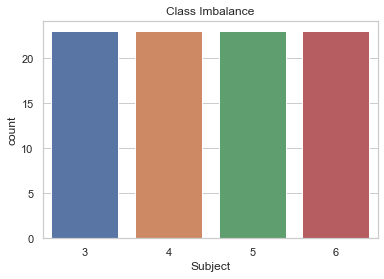

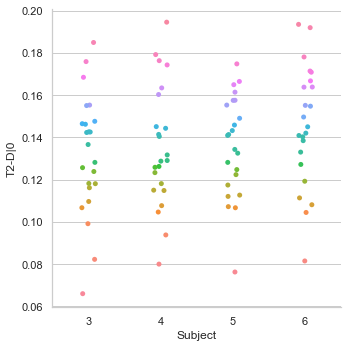

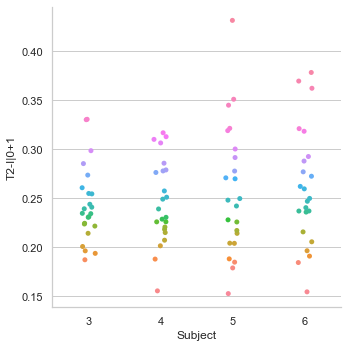

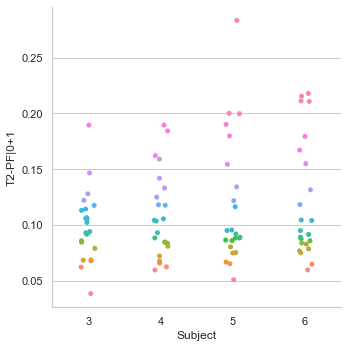

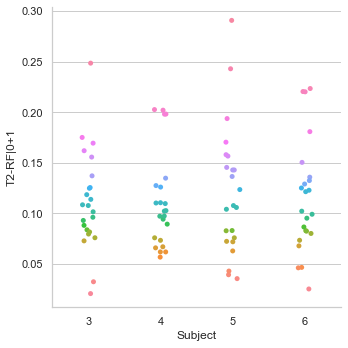

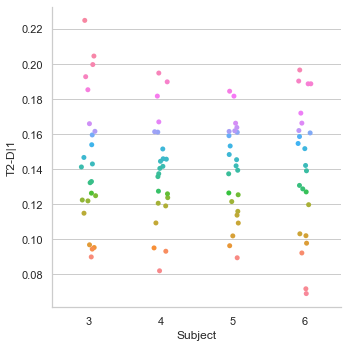

In [8]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [9]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['3' '4' '5' '6']


X | Features | Dataset Shape: (92, 37)
Y | Classes  | Dataset Shape: (92, 4)
Number of Classes: 4


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [10]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (73, 1, 37)
Y train shape: (73, 4)
X test shape: (19, 1, 37)
Y test shape: (19, 4)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [11]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [12]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [13]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 4 classes.
Epoch 1/500
12/12 [==============================] - 7s 9ms/step - loss: 1.6195 - accuracy: 0.2241
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 1.5535 - accuracy: 0.2759
Epoch 3/500
12/12 [==============================] - 0s 9ms/step - loss: 1.5801 - accuracy: 0.2759
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 1.5300 - accuracy: 0.2586
Epoch 5/500
12/12 [==============================] - 0s 11ms/step - loss: 1.4890 - accuracy: 0.1897
Epoch 6/500
12/12 [==============================] - 0s 10ms/step - loss: 1.5199 - accuracy: 0.1552
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 1.4401 - accuracy: 0.2586
Epoch 8/500
12/12 [==============================] - 0s 10ms/step - loss: 1.4144 - accuracy: 0.2069
Epoch 9/500
12/12 [==============================] - 0s 11ms/step - loss: 1.5065 - accuracy: 0.2069
Epoch 10/500
12/12 [==============================] - 0s 11ms/step - l

12/12 [==============================] - 0s 10ms/step - loss: 1.2123 - accuracy: 0.3621
Epoch 164/500
12/12 [==============================] - 0s 11ms/step - loss: 1.1712 - accuracy: 0.5000
Epoch 165/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1289 - accuracy: 0.4483
Epoch 166/500
12/12 [==============================] - 0s 10ms/step - loss: 1.2880 - accuracy: 0.4138
Epoch 167/500
12/12 [==============================] - 0s 10ms/step - loss: 1.2286 - accuracy: 0.4828
Epoch 168/500
12/12 [==============================] - 0s 13ms/step - loss: 1.2512 - accuracy: 0.4655
Epoch 169/500
12/12 [==============================] - 0s 10ms/step - loss: 1.2273 - accuracy: 0.4310
Epoch 170/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1284 - accuracy: 0.5517
Epoch 171/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1611 - accuracy: 0.5000
Epoch 172/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2003 - accuracy: 0.48

12/12 [==============================] - 0s 9ms/step - loss: 1.1123 - accuracy: 0.5172
Epoch 245/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0599 - accuracy: 0.5517
Epoch 246/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1208 - accuracy: 0.5517
Epoch 247/500
12/12 [==============================] - 0s 10ms/step - loss: 1.2010 - accuracy: 0.4310
Epoch 248/500
12/12 [==============================] - 0s 11ms/step - loss: 1.2232 - accuracy: 0.4828
Epoch 249/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1364 - accuracy: 0.5000
Epoch 250/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0794 - accuracy: 0.4828
Epoch 251/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1403 - accuracy: 0.5345
Epoch 252/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1439 - accuracy: 0.5345
Epoch 253/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1476 - accuracy: 0.4828
E

12/12 [==============================] - 0s 8ms/step - loss: 1.1115 - accuracy: 0.5345
Epoch 405/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1991 - accuracy: 0.4655
Epoch 406/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0542 - accuracy: 0.5517
Epoch 407/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0713 - accuracy: 0.6207
Epoch 408/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0526 - accuracy: 0.6207
Epoch 409/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9742 - accuracy: 0.5862
Epoch 410/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2461 - accuracy: 0.5517
Epoch 411/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9377 - accuracy: 0.6034
Epoch 412/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9620 - accuracy: 0.5517
Epoch 413/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9192 - accuracy: 0.6724
Ep

12/12 [==============================] - 0s 8ms/step - loss: 1.2755 - accuracy: 0.4310
Epoch 66/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1820 - accuracy: 0.4483
Epoch 67/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2094 - accuracy: 0.3966
Epoch 68/500
12/12 [==============================] - 0s 14ms/step - loss: 1.1912 - accuracy: 0.5000
Epoch 69/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2266 - accuracy: 0.4655
Epoch 70/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2017 - accuracy: 0.4828
Epoch 71/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1454 - accuracy: 0.4828
Epoch 72/500
12/12 [==============================] - 0s 9ms/step - loss: 1.3479 - accuracy: 0.4310
Epoch 73/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1912 - accuracy: 0.4483
Epoch 74/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0193 - accuracy: 0.5690
Epoch 75/500

12/12 [==============================] - 0s 8ms/step - loss: 1.0901 - accuracy: 0.5345
Epoch 228/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0607 - accuracy: 0.5690
Epoch 229/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9938 - accuracy: 0.5000
Epoch 230/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0270 - accuracy: 0.5172
Epoch 231/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0846 - accuracy: 0.5345
Epoch 232/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0788 - accuracy: 0.5345
Epoch 233/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0265 - accuracy: 0.5172
Epoch 234/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1313 - accuracy: 0.5172
Epoch 235/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0838 - accuracy: 0.5172
Epoch 236/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0263 - accuracy: 0.5345
Epoc

12/12 [==============================] - 0s 12ms/step - loss: 1.0377 - accuracy: 0.6379
Epoch 389/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9578 - accuracy: 0.6552
Epoch 390/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9200 - accuracy: 0.5690
Epoch 391/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0614 - accuracy: 0.5172
Epoch 392/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9924 - accuracy: 0.6379
Epoch 393/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9834 - accuracy: 0.5172
Epoch 394/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9485 - accuracy: 0.5862
Epoch 395/500
12/12 [==============================] - 0s 9ms/step - loss: 0.8725 - accuracy: 0.6897
Epoch 396/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9589 - accuracy: 0.6207
Epoch 397/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9071 - accuracy: 0.5862
Epo

12/12 [==============================] - 0s 8ms/step - loss: 1.3249 - accuracy: 0.3793
Epoch 49/500
12/12 [==============================] - 0s 8ms/step - loss: 1.3231 - accuracy: 0.3448
Epoch 50/500
12/12 [==============================] - 0s 9ms/step - loss: 1.3329 - accuracy: 0.3276
Epoch 51/500
12/12 [==============================] - 0s 9ms/step - loss: 1.3188 - accuracy: 0.3448
Epoch 52/500
12/12 [==============================] - 0s 9ms/step - loss: 1.4297 - accuracy: 0.3621
Epoch 53/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2703 - accuracy: 0.3793
Epoch 54/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2717 - accuracy: 0.3448
Epoch 55/500
12/12 [==============================] - 0s 8ms/step - loss: 1.3079 - accuracy: 0.3793
Epoch 56/500
12/12 [==============================] - 0s 8ms/step - loss: 1.3608 - accuracy: 0.3621
Epoch 57/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2265 - accuracy: 0.4828
Epoch 58/500


12/12 [==============================] - 0s 8ms/step - loss: 1.1723 - accuracy: 0.3621
Epoch 211/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2423 - accuracy: 0.4310
Epoch 212/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1244 - accuracy: 0.4828
Epoch 213/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1499 - accuracy: 0.4655
Epoch 214/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1852 - accuracy: 0.4483
Epoch 215/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2546 - accuracy: 0.3276
Epoch 216/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1216 - accuracy: 0.5517
Epoch 217/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1826 - accuracy: 0.4655
Epoch 218/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2524 - accuracy: 0.4483
Epoch 219/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0961 - accuracy: 0.5517
Epoc

12/12 [==============================] - 0s 9ms/step - loss: 1.1287 - accuracy: 0.5000
Epoch 292/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1505 - accuracy: 0.3966
Epoch 293/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0183 - accuracy: 0.6034
Epoch 294/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1794 - accuracy: 0.4310
Epoch 295/500
12/12 [==============================] - 0s 11ms/step - loss: 1.0356 - accuracy: 0.5000
Epoch 296/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0392 - accuracy: 0.5172
Epoch 297/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0677 - accuracy: 0.5690
Epoch 298/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1725 - accuracy: 0.4310
Epoch 299/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0734 - accuracy: 0.6552
Epoch 300/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1033 - accuracy: 0.4828


12/12 [==============================] - 0s 9ms/step - loss: 1.0954 - accuracy: 0.6034
Epoch 453/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0505 - accuracy: 0.5517
Epoch 454/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9258 - accuracy: 0.5517
Epoch 455/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0026 - accuracy: 0.5172
Epoch 456/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0798 - accuracy: 0.4483
Epoch 457/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0621 - accuracy: 0.6034
Epoch 458/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2955 - accuracy: 0.3966
Epoch 459/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0951 - accuracy: 0.4655
Epoch 460/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9729 - accuracy: 0.6034
Epoch 461/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9460 - accuracy: 0.6034
Epo

12/12 [==============================] - 0s 8ms/step - loss: 1.1308 - accuracy: 0.4915
Epoch 114/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1158 - accuracy: 0.5424
Epoch 115/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2424 - accuracy: 0.5085
Epoch 116/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0865 - accuracy: 0.5254
Epoch 117/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0606 - accuracy: 0.4746
Epoch 118/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1943 - accuracy: 0.4407
Epoch 119/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1516 - accuracy: 0.5085
Epoch 120/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0589 - accuracy: 0.5254
Epoch 121/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1533 - accuracy: 0.5085
Epoch 122/500
12/12 [==============================] - 0s 9ms/step - loss: 1.0887 - accuracy: 0.5424
Epoc

12/12 [==============================] - 0s 11ms/step - loss: 1.0978 - accuracy: 0.5424
Epoch 275/500
12/12 [==============================] - 0s 11ms/step - loss: 1.0550 - accuracy: 0.4915
Epoch 276/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1680 - accuracy: 0.5085
Epoch 277/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0700 - accuracy: 0.5254
Epoch 278/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1051 - accuracy: 0.4915
Epoch 279/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1251 - accuracy: 0.5085
Epoch 280/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2615 - accuracy: 0.4407
Epoch 281/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1027 - accuracy: 0.5763
Epoch 282/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1035 - accuracy: 0.5593
Epoch 283/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9381 - accuracy: 0.6102


12/12 [==============================] - 0s 8ms/step - loss: 0.9837 - accuracy: 0.5763
Epoch 356/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0832 - accuracy: 0.5254
Epoch 357/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9766 - accuracy: 0.5424
Epoch 358/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1283 - accuracy: 0.5932
Epoch 359/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0875 - accuracy: 0.4915
Epoch 360/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9122 - accuracy: 0.5593
Epoch 361/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0984 - accuracy: 0.5085
Epoch 362/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0114 - accuracy: 0.5085
Epoch 363/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0227 - accuracy: 0.5424
Epoch 364/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9744 - accuracy: 0.5932
Epoc

12/12 [==============================] - 0s 9ms/step - loss: 1.0248 - accuracy: 0.5254
Epoch 437/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1576 - accuracy: 0.4746
Epoch 438/500
12/12 [==============================] - 0s 9ms/step - loss: 0.8822 - accuracy: 0.5932
Epoch 439/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9363 - accuracy: 0.5593
Epoch 440/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1446 - accuracy: 0.4576
Epoch 441/500
12/12 [==============================] - 0s 8ms/step - loss: 1.0793 - accuracy: 0.4915
Epoch 442/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9459 - accuracy: 0.5763
Epoch 443/500
12/12 [==============================] - 0s 9ms/step - loss: 0.9670 - accuracy: 0.5593
Epoch 444/500
12/12 [==============================] - 0s 8ms/step - loss: 0.9483 - accuracy: 0.6271
Epoch 445/500
12/12 [==============================] - 0s 8ms/step - loss: 0.8743 - accuracy: 0.5932
Epoc

12/12 [==============================] - 0s 9ms/step - loss: 1.3079 - accuracy: 0.3051
Epoch 98/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2756 - accuracy: 0.4068
Epoch 99/500
12/12 [==============================] - 0s 8ms/step - loss: 1.3004 - accuracy: 0.3559
Epoch 100/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1763 - accuracy: 0.4746
Epoch 101/500
12/12 [==============================] - 0s 8ms/step - loss: 1.3585 - accuracy: 0.3220
Epoch 102/500
12/12 [==============================] - 0s 9ms/step - loss: 1.3333 - accuracy: 0.3898
Epoch 103/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2354 - accuracy: 0.3559
Epoch 104/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2717 - accuracy: 0.4407
Epoch 105/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1772 - accuracy: 0.4068
Epoch 106/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2927 - accuracy: 0.3898
Epoch 

12/12 [==============================] - 0s 9ms/step - loss: 1.1470 - accuracy: 0.4068
Epoch 260/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1855 - accuracy: 0.3559
Epoch 261/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2160 - accuracy: 0.5085
Epoch 262/500
12/12 [==============================] - 0s 8ms/step - loss: 1.2260 - accuracy: 0.3051
Epoch 263/500
12/12 [==============================] - 0s 9ms/step - loss: 1.2022 - accuracy: 0.4237
Epoch 264/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1108 - accuracy: 0.4237
Epoch 265/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1897 - accuracy: 0.4407
Epoch 266/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1553 - accuracy: 0.3898
Epoch 267/500
12/12 [==============================] - 0s 8ms/step - loss: 1.1679 - accuracy: 0.4915
Epoch 268/500
12/12 [==============================] - 0s 9ms/step - loss: 1.1467 - accuracy: 0.5085
Epoc

Epoch 421/500
12/12 [==============================] - 0s 11ms/step - loss: 1.1451 - accuracy: 0.4407
Epoch 422/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1031 - accuracy: 0.4237
Epoch 423/500
12/12 [==============================] - 0s 10ms/step - loss: 1.2331 - accuracy: 0.3898
Epoch 424/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0643 - accuracy: 0.4407
Epoch 425/500
12/12 [==============================] - 0s 10ms/step - loss: 1.2042 - accuracy: 0.4915
Epoch 426/500
12/12 [==============================] - 0s 11ms/step - loss: 1.0507 - accuracy: 0.5763
Epoch 427/500
12/12 [==============================] - 0s 12ms/step - loss: 1.1581 - accuracy: 0.5254
Epoch 428/500
12/12 [==============================] - 0s 11ms/step - loss: 1.1450 - accuracy: 0.4237
Epoch 429/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0905 - accuracy: 0.4068
Epoch 430/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0769

3/3 [==============================] - 2s 4ms/step - loss: 2.1584 - accuracy: 0.0714


##### Get Validation Accuracy

In [14]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 20.38% (with standard deviation of 7.15%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [15]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 4 classes.
Epoch 1/500
15/15 [==============================] - 8s 11ms/step - loss: 1.5398 - accuracy: 0.1644
Epoch 2/500
15/15 [==============================] - 0s 12ms/step - loss: 1.4872 - accuracy: 0.2466
Epoch 3/500
15/15 [==============================] - 0s 11ms/step - loss: 1.5448 - accuracy: 0.1370
Epoch 4/500
15/15 [==============================] - 0s 10ms/step - loss: 1.4403 - accuracy: 0.2877
Epoch 5/500
15/15 [==============================] - 0s 10ms/step - loss: 1.4721 - accuracy: 0.2055
Epoch 6/500
15/15 [==============================] - 0s 10ms/step - loss: 1.4337 - accuracy: 0.2055
Epoch 7/500
15/15 [==============================] - 0s 10ms/step - loss: 1.4300 - accuracy: 0.2329
Epoch 8/500
15/15 [==============================] - 0s 10ms/step - loss: 1.4188 - accuracy: 0.3014
Epoch 9/500
15/15 [==============================] - 0s 10ms/step - loss: 1.4498 - accuracy: 0.2740
Epoch 10/500
15/15 [==============================] - 0s 10ms/step -

15/15 [==============================] - 0s 10ms/step - loss: 1.1704 - accuracy: 0.4658
Epoch 162/500
15/15 [==============================] - 0s 10ms/step - loss: 1.1801 - accuracy: 0.3699
Epoch 163/500
15/15 [==============================] - 0s 10ms/step - loss: 1.1873 - accuracy: 0.4247
Epoch 163: early stopping


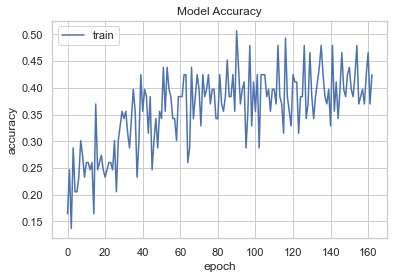

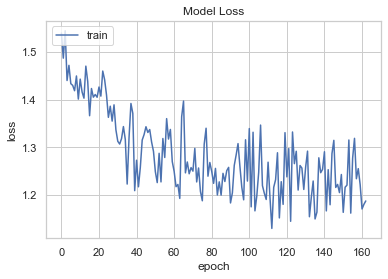

In [16]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [17]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            301056    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [18]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 31.579%


##### Confusion Matrix

19 is the number of test value in kfold_val / train_test_split


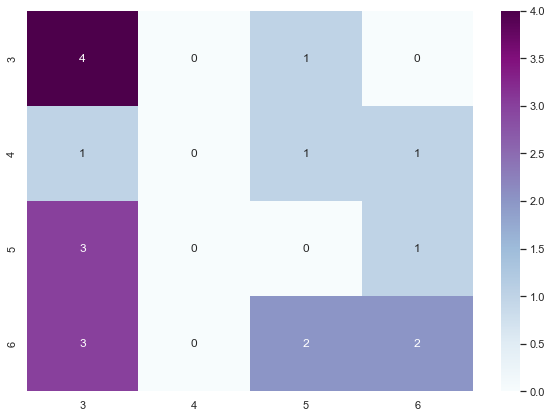

In [19]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

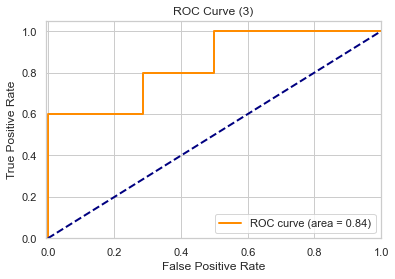

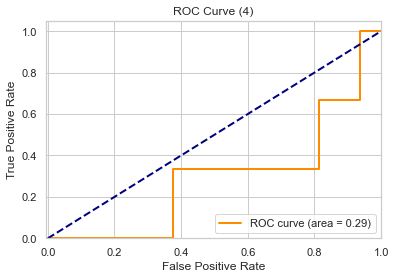

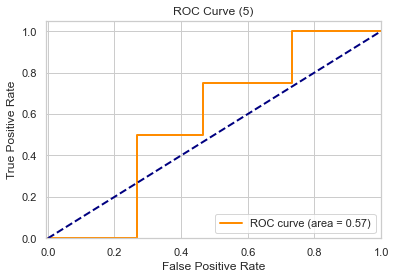

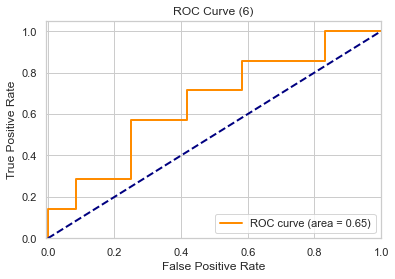

In [20]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

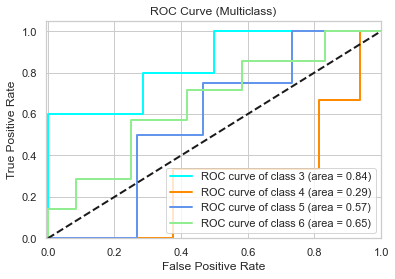

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

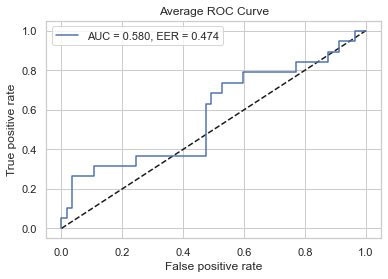

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [23]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['3' '4' '5' '6']


X | Features | Dataset Shape: (92, 37)
Y | Classes  | Dataset Shape: (92, 4)
There are a total of 4 classes.
Epoch 1/500
19/19 [==============================] - 7s 10ms/step - loss: 1.4752 - accuracy: 0.2391
Epoch 2/500
19/19 [==============================] - 0s 9ms/step - loss: 1.3959 - accuracy: 0.2826
Epoch 3/500
19/19 [==============================] - 0s 10ms/step - loss: 1.4313 - accuracy: 0.2717
Epoch 4/500
19/19 [==============================] - 0s 10ms/step - loss: 1.4277 - accuracy: 0.2391
Epoch 5/500
19/19 [==============================] - 0s 10ms/step - loss: 1.4422 - accuracy: 0.1413
Epoch 6/500
19/19 [==============================] - 0s 10ms/step - loss: 1.4132 - accuracy: 0.2826
Epoch 7/500
19/19 [==============================] - 0s 10ms/step - loss: 1.4257 - accuracy: 0.2391
Epoch 8/500
19/19 [==============================] - 0s 9ms/step - loss: 1.3909 - accuracy: 0.2826
Epoch 9/500
19/19 [=================

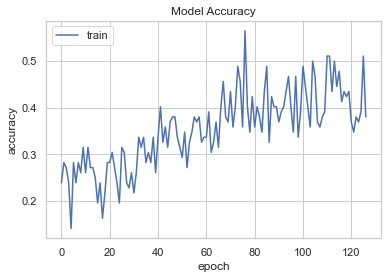

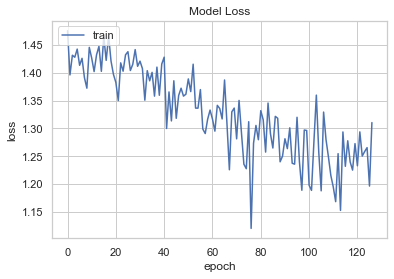

In [24]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [25]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [26]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [27]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,3,3,why margin,0.156546,0.305911,0.149060,0.149365,0.156852,0.276707,0.203404,...,0.211456,0.157810,0.181083,0.065032,0.023273,0.116051,0.152623,0.033008,0.036572,0.119616
1,3,3,war encalm,0.160672,0.335976,0.110433,0.175304,0.225543,0.271715,0.103903,...,0.222109,0.189098,0.239651,0.133426,0.050553,0.106225,0.214052,0.070148,0.107827,0.143904
2,4,4,hood whips,0.132462,0.183651,0.102099,0.051189,0.081552,0.254179,0.131667,...,0.060127,0.141966,0.191998,0.056452,0.050031,0.135546,0.240348,0.090543,0.104802,0.149805
3,4,4,shim sweat,0.151514,0.161692,0.042774,0.010178,0.118918,0.178971,0.065487,...,0.203171,0.150809,0.246943,0.104717,0.096134,0.142226,0.237926,0.076469,0.095700,0.161457
4,5,5,henry haji,0.128684,0.227950,0.091504,0.099266,0.136446,0.238963,0.099947,...,0.141130,0.160158,0.299132,0.167161,0.138973,0.131971,0.211203,0.059170,0.079232,0.152033


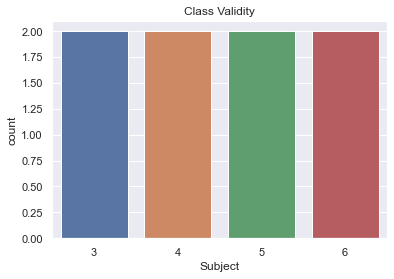

In [28]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [29]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['3', '4', '5', '6']


In [30]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

Accuracy of the Model is: 0/8 (0.0%)


In [ ]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))